## Bayesian Neural Networks in Keras and TensorFlow 2.0

In [1]:
#TODO: PUT RANDOM SEED FOR RESULT SECURING IN DEMOS
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
print('TensorFlow version (expected = 2.0.0-beta1):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0-beta1): 2.0.0-beta1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.9.0-dev20190912


In [4]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## We are all set up, lets go!

We are using MNIST dataset!
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


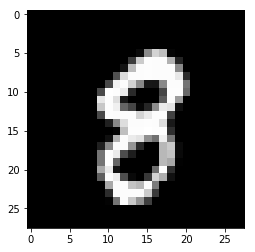

In [5]:
"""
first, we load the dataset. We are trying to do it first with MNIST
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using MNIST dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, 0], cmap='gist_gray')

In [6]:
def build_bayesian_bcnn_model(input_shape):
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

In [7]:
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [8]:
@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [9]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(y_train, axis=1))

In [10]:
for i in range(35):
    loss = train_step(X_train, y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, y_train)
    print("Epoch: {}: loss = {} , accuracy = {}".format(i, loss, acc))

W0912 17:22:46.940508 139683306188544 deprecation.py:323] From /home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0: loss = 11.073323249816895 , accuracy = 0.1221
Epoch: 1: loss = 6.9439697265625 , accuracy = 0.22618333333333332
Epoch: 2: loss = 6.832186222076416 , accuracy = 0.23513333333333333
Epoch: 3: loss = 6.935305118560791 , accuracy = 0.2617833333333333
Epoch: 4: loss = 4.872640609741211 , accuracy = 0.3858333333333333
Epoch: 5: loss = 3.878277063369751 , accuracy = 0.39986666666666665
Epoch: 6: loss = 2.8462696075439453 , accuracy = 0.43205
Epoch: 7: loss = 1.9528741836547852 , accuracy = 0.5061
Epoch: 8: loss = 1.7277404069900513 , accuracy = 0.5768
Epoch: 9: loss = 1.5229679346084595 , accuracy = 0.6357833333333334
Epoch: 10: loss = 1.2816596031188965 , accuracy = 0.7013166666666667
Epoch: 11: loss = 0.9405604600906372 , accuracy = 0.7491666666666666
Epoch: 12: loss = 0.7817077040672302 , accuracy = 0.7639666666666667
Epoch: 13: loss = 0.7388714551925659 , accuracy = 0.7898333333333334
Epoch: 14: loss = 0.7215876579284668 , accuracy = 0.8225
Epoch: 15: loss = 0.6683122515678406 ,

In [29]:
n_mc_run = 50
med_prob_thres = 0.20

y_pred_logits_list = [bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9999
Unrecognizable samples: [6572]
Test accuracy on MNIST (recognizable samples): 0.9427942794279428
Test accuracy on MNIST (unrecognizable samples): 0.0


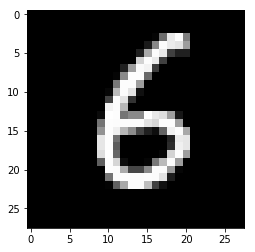

In [30]:
test = X_train[6572].reshape(-1, 28, 28, 1)
plt.imshow(X_train[6572, :, :, 0], cmap='gist_gray')